In [29]:
%load_ext autoreload
%autoreload 2
from naml.dataset import Datasets, DatasetRemote
datasets = Datasets("~/naml-data")
import re

timemachine = DatasetRemote("timemachine","http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt")
steinsgate = DatasetRemote("steinsgate","https://raw.githubusercontent.com/mos9527/sghd-patch-zhs/refs/heads/master/scripts/script/0x52_SG04_24.SCX.txt")
lines = datasets.fetch(steinsgate).readlines()

lines = [re.sub('[\[\]「『 』」%=0-9a-zA-Z"\ ]+', ' ', line).strip() for line in lines]
lines[0], lines[10]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<>:11: SyntaxWarning: invalid escape sequence '\['
<>:11: SyntaxWarning: invalid escape sequence '\['
C:\Users\mos9527\AppData\Local\Temp\ipykernel_37856\2960474529.py:11: SyntaxWarning: invalid escape sequence '\['
  lines = [re.sub('[\[\]「『 』」%=0-9a-zA-Z"\ ]+', ' ', line).strip() for line in lines]


('伦太郎 现在开始对 ワ 作战的概要进行说明', '伦太郎 咕咕咕,真是每次都要抬杠啊 克里斯蒂娜 你实在不理解人类的心理')

In [30]:
from naml.text import Vocabulary
tokens = Vocabulary.tokenize_char(lines)
corpus = Vocabulary.to_corpus(tokens)
vocab = Vocabulary(corpus)
print(*zip(vocab.top_tokens[:10],vocab.freqs(vocab.top_tokens[:10])))

(' ', 194) ('的', 104) ('⋯', 100) (',', 76) ('我', 74) ('。', 64) ('是', 60) ('不', 60) ('莉', 59) ('红', 53)


## RNN
$$
\mathbf{H_t} = \phi(\mathbf{X_t}\mathbf{W_{xh}} + \mathbf{H_{t-1}}\mathbf{W_{hh}} + \mathbf{b_h}) \\
\mathbf{Y_t} = \mathbf{H_t}\mathbf{W_{ho}} + \mathbf{b_o}
$$
$$
\mathbf{H} = \text{hidden state} \\
\mathbf{X} = \text{input} \\
\mathbf{Y} = \text{output} \\
\mathbf{W_{xh}} = \text{input weight}\ \mathbf{W_{hh}} = \text{hidden weight}\ \mathbf{W_{ho}} = \text{output weight}\ \mathbf{b_h} = \text{hidden bias}\ \mathbf{b_o} = \text{output bias}
$$

In [31]:
from naml.modules import nn, torch

class RNN(nn.Module):
    # GRU for implementation
    def __init__(self, vocab_size, num_hiddens, num_layers):
        super().__init__()
        self.vocab_size, self.num_hiddens, self.num_layers = vocab_size, num_hiddens, num_layers
        self.rnn = nn.GRU(vocab_size, num_hiddens, num_layers)
        self.dense = nn.Linear(num_hiddens, vocab_size)       

    def forward(self, X : torch.Tensor, H : torch.Tensor):
        # X[timestep,batch_size,vocab_size]
        X = nn.functional.one_hot(X.T.long(), self.vocab_size).float()
        Y, H = self.rnn(X, H)
        # Y[timestep,batch_size,num_hiddens]
        Y = Y.reshape(-1, Y.shape[-1])
        # Y[timestep*batch_size,num_hiddens]
        Y = self.dense(Y)        
        return Y, H
    
    def begin_state(self, device : torch.device, batch_size : int):
        return torch.zeros((self.num_layers, batch_size, self.num_hiddens), device=device)

device = torch.device('cpu')
net = RNN(len(vocab), 256, 1)
net = net.to(device)
def predict(net, prefix, num_preds):
    H = net.begin_state(device, 1)
    prefix = vocab.tokenize_char([prefix])[0]
    output = [vocab[prefix[0]][0]]
    # Hidden state warmup
    for token in prefix[1:]:
        X = torch.tensor([[output[-1]]], device=device).reshape((1,1))
        Y, H = net(X, H)
        output.append(vocab[token][0])
    # Predictions
    for pred in range(num_preds):
        X = torch.tensor([[output[-1]]], device=device).reshape((1,1))
        Y, H = net(X, H)
        Y : torch.Tensor = Y.squeeze(0)
        output.append(int(Y.argmax(0)))
    return ''.join([vocab.ivocab[i] for i in output])

predict(net, '是我', 10)

'是我排⋯东刀刀刀刀刀刀刀'

## Perplexity
$$
\text{Perplexity} = \exp\left(-\frac{1}{N}\sum_{i=1}^{N}\log p(x_i)\right),\text {or equivalently} \ \exp(\text{nn.CrossEntropyLoss}\ \text{with mean reduction})
$$


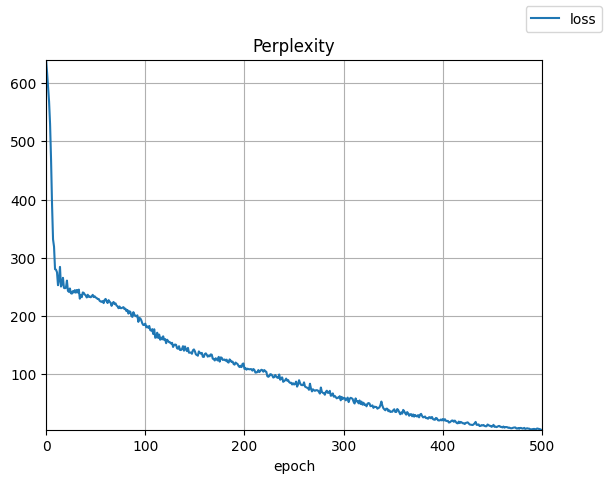

  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

In [32]:
import math
from naml.plot import tqdm
from naml.sequence import seq_partition_sample_sequential
from naml.util import run_epochs
corpus_indices = vocab.to_indices(corpus)

batch_size, num_steps = 32, 35

net = RNN(len(vocab), 256, 1)
net = net.to(device)
# XXX: Grad clipping
def train(net, lr, num_epochs):
    loss = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(net.parameters(), lr=lr)
    @run_epochs("Perplexity")
    def train_epoch():
        H = net.begin_state(device, batch_size)                
        loss_sum, count = 0, 0
        train_iter = seq_partition_sample_sequential(corpus_indices, batch_size, num_steps)
        for X, Y in train_iter:
            H.detach_() # Hidden parameters are not to be update
    
            y = Y.T.reshape(-1) # [batch_1_step_1, batch_2_step_1, ...]
            X = X.to(device)
            y = y.to(device)
            Y_hat, H = net(X, H)
            l = loss(Y_hat, y.long()).mean()
            optim.zero_grad()
            l.backward()
            optim.step()        
            loss_sum += l.detach() * y.numel()
            count += y.numel()
        print(predict(net, "是我", 50), end='\r')
        return math.exp(loss_sum/count)
    train_epoch(num_epochs)

train(net, 1, 500)

In [36]:
predict(net, '白痴', 100)

'白痴⋯⋯伦太郎 什么⋯⋯?红莉栖 你之以,是没有事我。不如桶子对出至 我放到自己是最能的她狂她不行为我说话红莉栖 所以,白痴⋯⋯伦太郎 我的电抱歉⋯⋯不过桶子,和我一起死了你的事红莉栖 我来想一下,你不是'